## Import Packages

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from category_encoders.target_encoder import TargetEncoder
import matplotlib.pyplot as plt

## Read and inspect data

The outcome variable is `PerformanceRating`

In [ ]:
# Read dataset
df = pd.read_csv("https://raw.githubusercontent.com/ashish-cell/BADM-211-FA21/main/Data/HR_Churn__23.csv", parse_dates= ["JoinDate"])

In [ ]:
df.columns

Index(['Gone', 'JoinDate', 'Age', 'BusinessTravel', 'DistanceFromHome',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'PerformanceRating'],
      dtype='object')

In [ ]:
df.head()

,Gone,JoinDate,Age,BusinessTravel,DistanceFromHome,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PerformanceRating
0,Yes,2020-10-04,41.0,Travel_Rarely,1,2,Female,3,2,Sales Executive,4,Single,5993,8.0,3
1,No,2019-03-19,49.0,Travel_Frequently,8,3,Male,2,2,Research Scientist,2,Married,5130,1.0,4
2,Yes,2021-10-03,37.0,Travel_Rarely,2,4,Male,2,1,Laboratory Technician,3,Single,2090,6.0,3
3,No,2019-02-09,33.0,Travel_Frequently,3,4,NaN,3,1,Research Scientist,3,Married,2909,1.0,3
4,No,2021-02-27,27.0,Travel_Rarely,2,1,Male,3,1,Laboratory Technician,2,Married,3468,9.0,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Gone                     1500 non-null   object        
 1   JoinDate                 1500 non-null   datetime64[ns]
 2   Age                      1495 non-null   float64       
 3   BusinessTravel           1500 non-null   object        
 4   DistanceFromHome         1500 non-null   int64         
 5   EnvironmentSatisfaction  1500 non-null   int64         
 6   Gender                   1493 non-null   object        
 7   JobInvolvement           1500 non-null   int64         
 8   JobLevel                 1500 non-null   int64         
 9   JobRole                  1500 non-null   object        
 10  JobSatisfaction          1500 non-null   int64         
 11  MaritalStatus            1500 non-null   object        
 12  MonthlyIncome            1500 non-

In [ ]:
df.describe()

,Age,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PerformanceRating
count,1495.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1494.000000,1500.000000
mean,36.956522,9.224000,2.719333,2.728667,2.067333,2.734000,6720.708000,2.686747,3.156667
std,9.116830,8.152595,1.097890,0.710433,1.110385,1.102749,6089.754371,2.509379,0.363607
min,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1009.000000,0.000000,3.000000
25%,30.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2928.250000,1.000000,3.000000
50%,36.000000,7.000000,3.000000,3.000000,2.000000,3.000000,4961.500000,2.000000,3.000000
75%,43.000000,14.000000,4.000000,3.000000,3.000000,4.000000,8465.750000,4.000000,3.000000
max,60.000000,29.000000,4.000000,4.000000,5.000000,4.000000,95209.000000,9.000000,4.000000


In [ ]:
df.isnull().sum()

Gone                       0
JoinDate                   0
Age                        5
BusinessTravel             0
DistanceFromHome           0
EnvironmentSatisfaction    0
Gender                     7
JobInvolvement             0
JobLevel                   0
JobRole                    0
JobSatisfaction            0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         6
PerformanceRating          0
dtype: int64

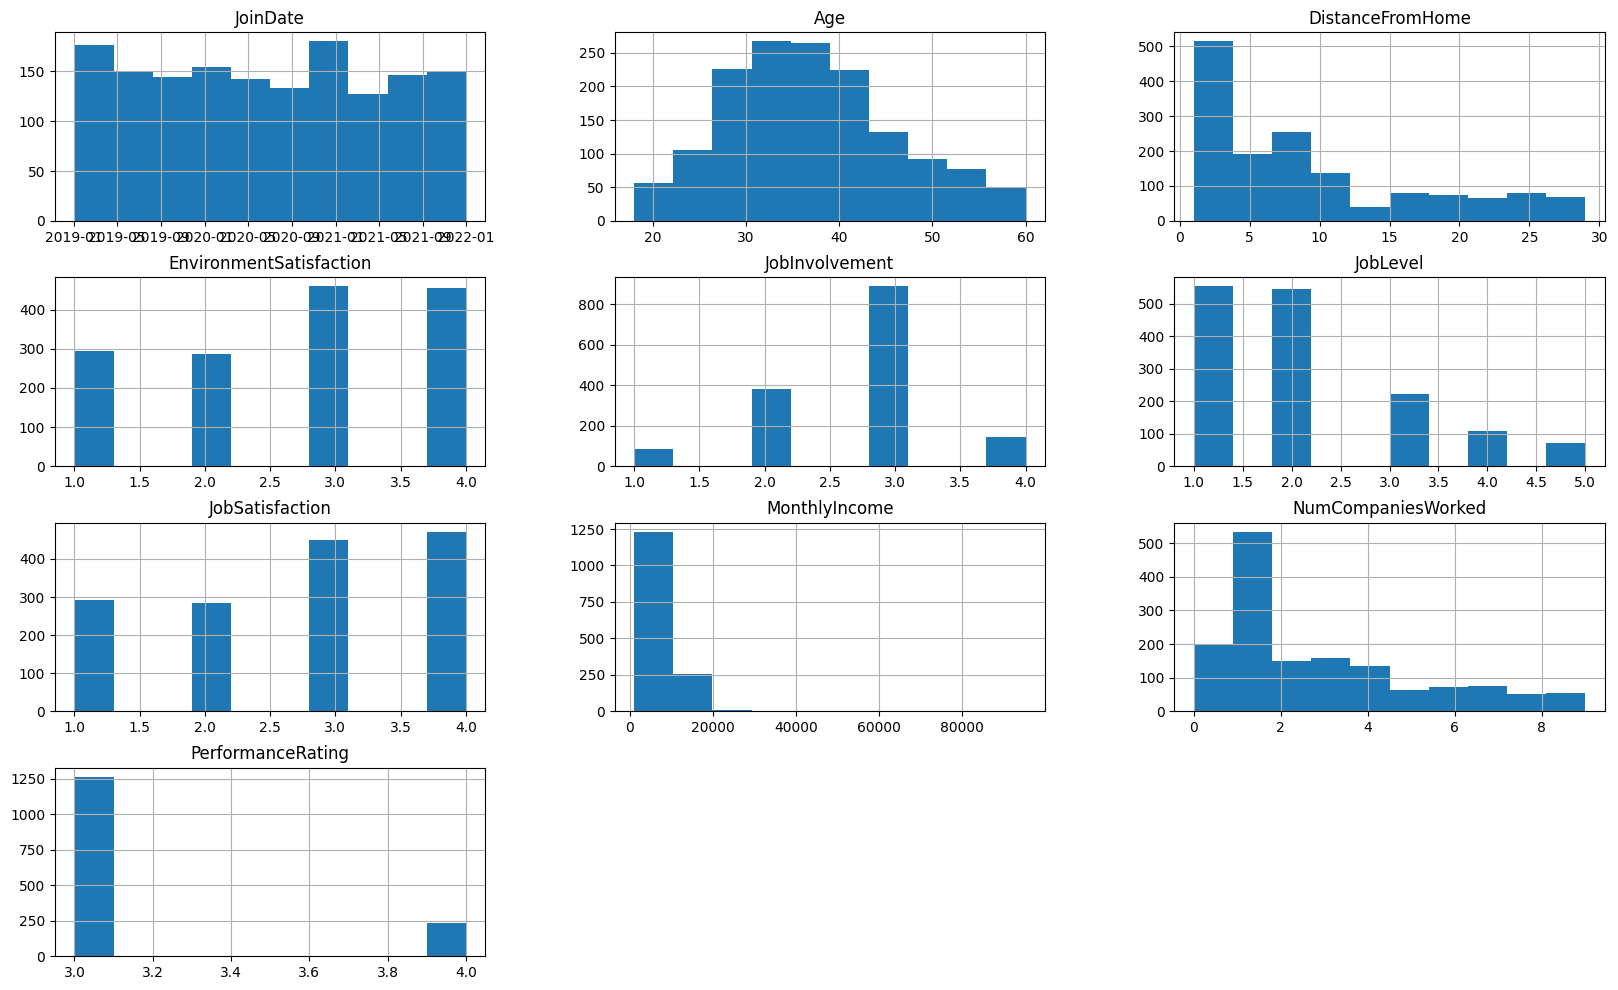

In [ ]:

df.hist(figsize= (20,12))

plt.show()

1. `Age`: mean imputation because quite normal
2. `NumCompaniesWorked`: median imputation becuase of right skew
3. `Gender`: Constant value with "missing"

We need to do the following:

1. `Age`:  i) Mean impute along with missing indicator ii) Discretize in to four bins of equal width and Encode the bins into ordinal categories
2. `NumCompaniesWorked`:  i) Median Impute and add a missing indicator
3. `Gender`: Impute missing values by a string "missing"

## Train Test Split

In [ ]:
X = df.drop(columns = "PerformanceRating")

y = df.PerformanceRating

In [ ]:
train_X, test_X, train_y, test_y  = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Initialize Missing Indicator

In [ ]:
miss_indicator = MissingIndicator()

miss_indicator.set_output(transform= "pandas")

MissingIndicator()

Let's create separate `Pipeline` for each variable and put them in a `ColumnTransformer`

### Pipeline for `Age`

In [ ]:
pipe_age = Pipeline(steps = [("mean_impute", SimpleImputer(strategy= "mean", add_indicator= True)),
                            ("discretize", KBinsDiscretizer(n_bins = 4, strategy='uniform', encode= "ordinal"))])

pipe_age.set_output(transform= "pandas")

Pipeline(steps=[('mean_impute', SimpleImputer(add_indicator=True)),
                ('discretize',
                 KBinsDiscretizer(encode='ordinal', n_bins=4,
                                  strategy='uniform'))])

### Pipeline for `NumberofCompaniesWorked`

In [ ]:
pipe_ncw = Pipeline(steps = [("median_impute", SimpleImputer(strategy= "median", add_indicator= True))])

pipe_ncw.set_output(transform= "pandas")

Pipeline(steps=[('median_impute',
                 SimpleImputer(add_indicator=True, strategy='median'))])

### Pipeline for `Gender`

In [ ]:
pipe_gender = Pipeline(steps = [("missing_impute", SimpleImputer(strategy= "constant", fill_value= "missing")),
                                ("ohe", OneHotEncoder(drop= "first", sparse_output= False))])

pipe_gender.set_output(transform= "pandas")

Pipeline(steps=[('missing_impute',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('ohe', OneHotEncoder(drop='first', sparse_output=False))])

### Put all pipelines in a `ColumnTransformer` to apply them only on the desired set of columns

In [ ]:
ct = ColumnTransformer( transformers= [("age", pipe_age, ["Age"]),
                                       ("ncw", pipe_ncw, ["NumCompaniesWorked"]),
                                       ("gen", pipe_gender, ["Gender"])],
                                       remainder= "passthrough")

ct.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('age',
                                 Pipeline(steps=[('mean_impute',
                                                  SimpleImputer(add_indicator=True)),
                                                 ('discretize',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=4,
                                                                   strategy='uniform'))]),
                                 ['Age']),
                                ('ncw',
                                 Pipeline(steps=[('median_impute',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['NumCompaniesWorked']),
                                ('gen',
                                 Pipeline(steps=[('missing_impute',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['Gender'])])

### Fit `ColumnTransFormer` on train_X

In [ ]:
ct.fit(train_X)

ColumnTransformer(remainder='passthrough',
                  transformers=[('age',
                                 Pipeline(steps=[('mean_impute',
                                                  SimpleImputer(add_indicator=True)),
                                                 ('discretize',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=4,
                                                                   strategy='uniform'))]),
                                 ['Age']),
                                ('ncw',
                                 Pipeline(steps=[('median_impute',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['NumCompaniesWorked']),
                                ('gen',
                                 Pipeline(steps=[('missing_impute',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['Gender'])])

### Transform `train_X` and `test_X`

In [ ]:
train_X_processed = ct.transform(train_X)

test_X_processed = ct.transform(test_X)

In [ ]:
# Check null values
train_X_processed.isnull().sum()

age__Age                                    0
age__missingindicator_Age                   0
ncw__NumCompaniesWorked                     0
ncw__missingindicator_NumCompaniesWorked    0
gen__Gender_Male                            0
gen__Gender_missing                         0
remainder__Gone                             0
remainder__JoinDate                         0
remainder__BusinessTravel                   0
remainder__DistanceFromHome                 0
remainder__EnvironmentSatisfaction          0
remainder__JobInvolvement                   0
remainder__JobLevel                         0
remainder__JobRole                          0
remainder__JobSatisfaction                  0
remainder__MaritalStatus                    0
remainder__MonthlyIncome                    0
dtype: int64

In [ ]:
# Check null values
test_X_processed.isnull().sum()

age__Age                                    0
age__missingindicator_Age                   0
ncw__NumCompaniesWorked                     0
ncw__missingindicator_NumCompaniesWorked    0
gen__Gender_Male                            0
gen__Gender_missing                         0
remainder__Gone                             0
remainder__JoinDate                         0
remainder__BusinessTravel                   0
remainder__DistanceFromHome                 0
remainder__EnvironmentSatisfaction          0
remainder__JobInvolvement                   0
remainder__JobLevel                         0
remainder__JobRole                          0
remainder__JobSatisfaction                  0
remainder__MaritalStatus                    0
remainder__MonthlyIncome                    0
dtype: int64

In [ ]:
# Check whether Age is discretized
train_X_processed.age__Age.value_counts()

1.0    508
2.0    324
0.0    224
3.0    144
Name: age__Age, dtype: int64

`Note - There could be alternative way to set up the preprocessings steps. The notebook shows only one of them.`